In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Loading openface model

In [5]:
from cpe775.networks.openface import OpenFace

In [6]:
ckpt = torch.load('../models/openface/nn4.small2.v1.pth')
openface = OpenFace()
openface.load_state_dict(ckpt['state_dict'])
openface.eval()

OpenFace (
  (layer1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (layer3): ReLU ()
  (layer4): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer5): LRN (
    (average): AvgPool2d (
    )
  )
  (layer6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (layer7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (layer8): ReLU ()
  (layer9): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  (layer11): ReLU ()
  (layer12): LRN (
    (average): AvgPool2d (
    )
  )
  (layer13): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer14): Inception (
    (seq_list): ModuleList (
      (0): Sequential (
        (1_conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (2_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (3_re

## Loading faces

In [7]:
import glob
from skimage import io
from sklearn.preprocessing import LabelEncoder

In [8]:
people = ['igor', 'rafael', 'felipe', 'matheus', 'cinelli']

In [9]:
from collections import OrderedDict

In [10]:
files = [str(f) for person in people for f in np.random.choice(glob.glob('../data/{}/cropped/*'.format(person)), 20, replace=False)]

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
X = np.stack([io.imread(f) for f in files], axis=0)/255
y = np.hstack([20*[person] for person in people])

In [13]:
le = LabelEncoder()

In [14]:
y = le.fit_transform(y)

In [15]:
X.shape

(100, 96, 96, 3)

In [16]:
y.shape

(100,)

In [17]:
from collections import Counter
Counter(y)

Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})

## Transform input

In [18]:
X_var = torch.autograd.Variable(torch.from_numpy(X.transpose((0, 3, 1, 2))), volatile=True).float()

In [19]:
X_var.size()

torch.Size([100, 3, 96, 96])

In [20]:
X_var

Variable containing:
( 0 , 0 ,.,.) = 
  0.9882  0.9961  0.9647  ...   0.5882  0.5804  0.5608
  0.9804  0.9686  0.9490  ...   0.5882  0.5725  0.5451
  0.9804  0.9451  0.9373  ...   0.5569  0.5529  0.5412
           ...             ⋱             ...          
  0.7137  0.7176  0.7216  ...   0.4353  0.4392  0.4471
  0.7059  0.7020  0.7020  ...   0.4275  0.4392  0.4431
  0.7176  0.7176  0.7137  ...   0.4196  0.4314  0.4392

( 0 , 1 ,.,.) = 
  0.9922  1.0000  0.9686  ...   0.4667  0.4588  0.4392
  0.9843  0.9725  0.9529  ...   0.4667  0.4510  0.4314
  0.9804  0.9490  0.9412  ...   0.4431  0.4471  0.4353
           ...             ⋱             ...          
  0.9176  0.9216  0.9255  ...   0.3137  0.3176  0.3176
  0.9020  0.9059  0.9059  ...   0.3059  0.3098  0.3137
  0.9137  0.9137  0.9098  ...   0.2980  0.3059  0.3137

( 0 , 2 ,.,.) = 
  1.0000  1.0000  0.9765  ...   0.3961  0.3804  0.3608
  0.9922  0.9804  0.9608  ...   0.3961  0.3804  0.3608
  0.9882  0.9569  0.9490  ...   0.3804  0.3804

In [21]:
X_npy = openface(X_var).data.cpu().numpy()

In [43]:
%timeit openface(X_var[0][np.newaxis, ...]).data.cpu().numpy()

60.1 ms ± 9.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Training an SVM classifier

In [22]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline

/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(X_npy, y, X, test_size=0.2, random_state=42, stratify=y)

In [24]:
k_fold = StratifiedKFold(10)

In [25]:
model = SVC(probability=True, C=1, kernel='linear')
# model = SVC(C=1, kernel='rbf', probability=True, gamma=2)

In [26]:
scores = cross_val_score(model, X_train, y_train, cv=5)

In [27]:
scores

array([ 0.9       ,  0.93333333,  0.93333333,  0.93333333,  0.93333333])

In [28]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.03)


In [29]:
predict = cross_val_predict(model, X_npy, y, cv=10)

In [30]:
predict

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
predict = model.predict_proba(X_test)

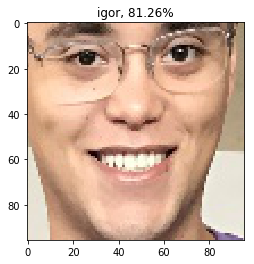

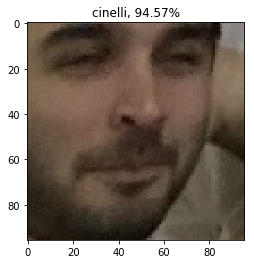

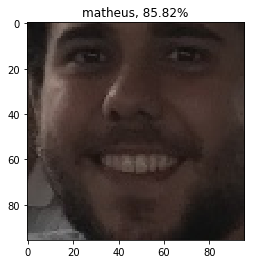

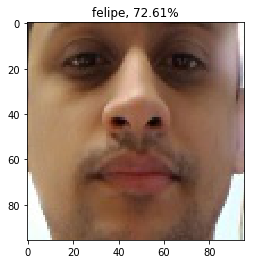

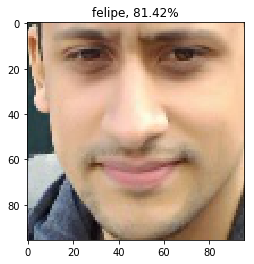

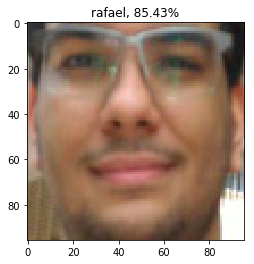

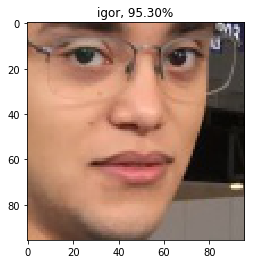

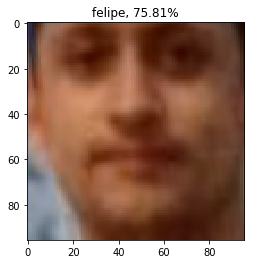

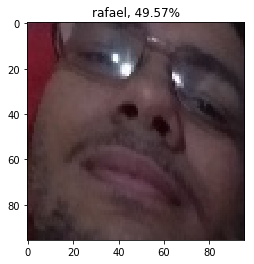

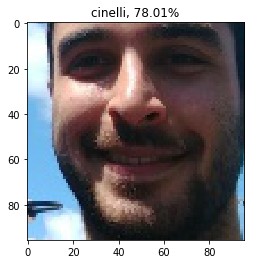

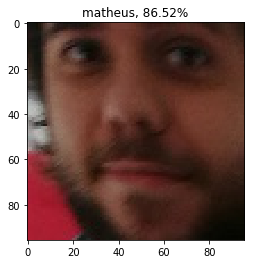

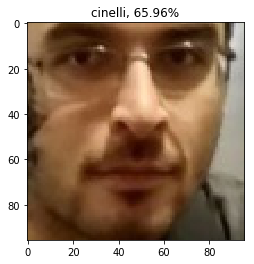

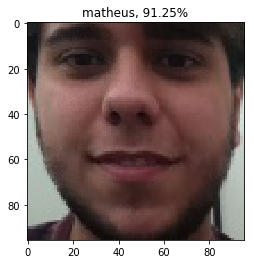

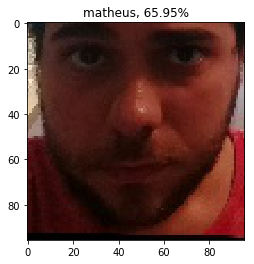

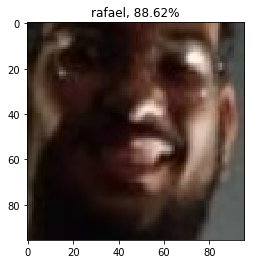

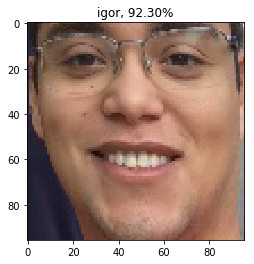

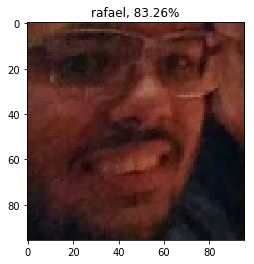

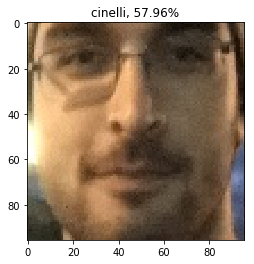

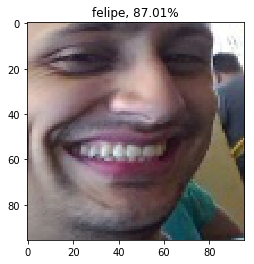

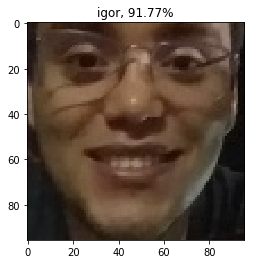

In [33]:
for i, image in enumerate(images_test):
    plt.figure()
    plt.imshow(image)
    idx = np.argmax(predict[i])
    plt.title('{}, {:.2f}%'.format(le.inverse_transform(idx), predict[i][idx]*100))

## Saving the model

In [34]:
from sklearn.externals import joblib

In [35]:
joblib.dump((model, le), '../models/face_classification_svm.pkl')

['../models/face_classification_svm.pkl']

## Unknown faces

In [36]:
unk_faces = [io.imread(f) for f in np.random.choice(glob.glob('../data/unknown/cropped/*'), 40, replace=False)]
unk_faces = np.stack(unk_faces, axis=0)/255

In [37]:
unk_var = torch.autograd.Variable(torch.from_numpy(unk_faces.transpose((0, 3, 1, 2))), volatile=True).float()

In [38]:
unk_emb = openface(unk_var).data.cpu().numpy()

In [39]:
predict = model.predict_proba(unk_emb)

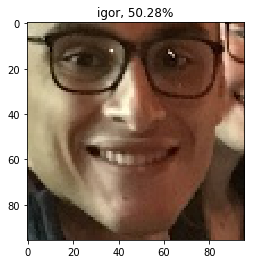

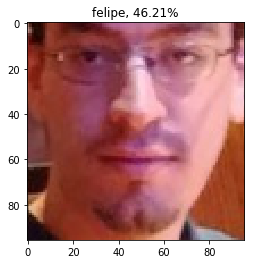

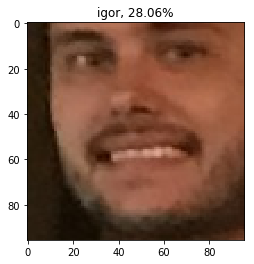

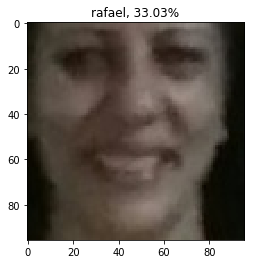

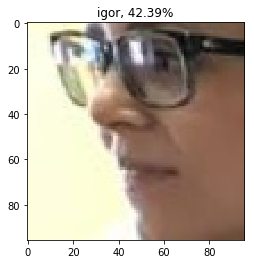

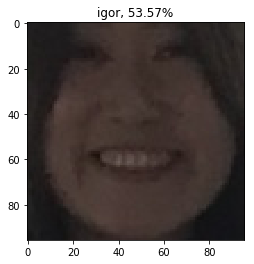

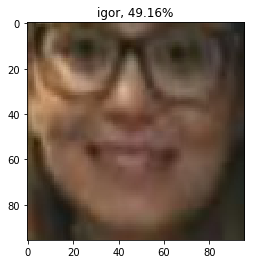

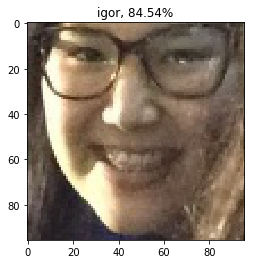

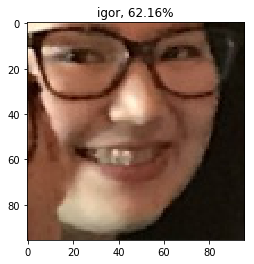

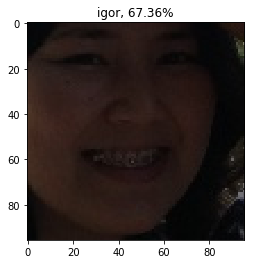

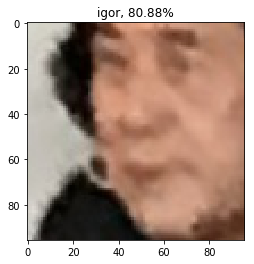

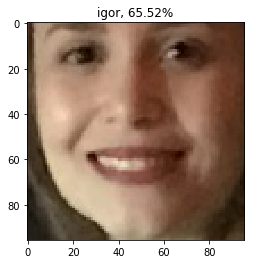

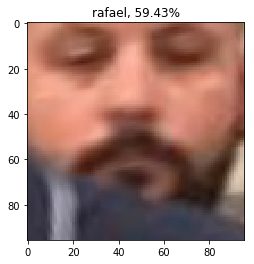

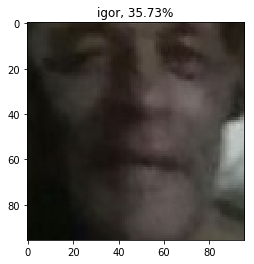

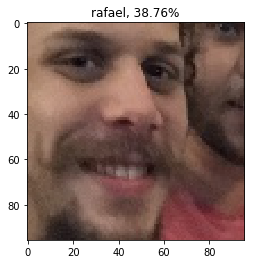

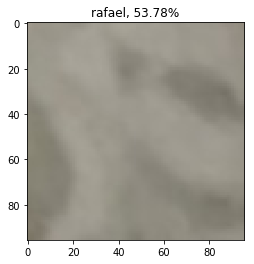

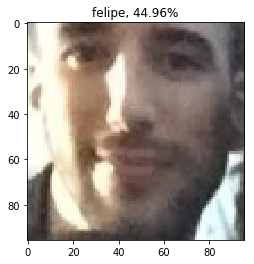

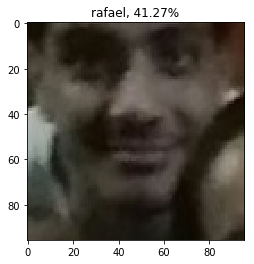

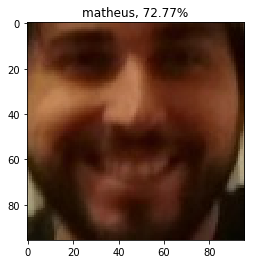

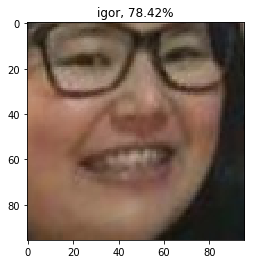

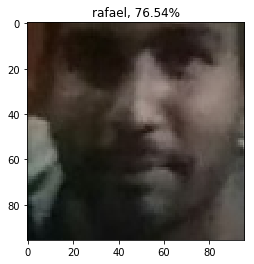

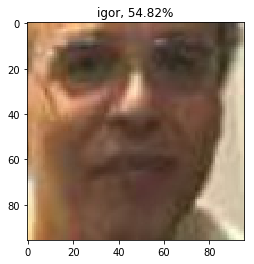

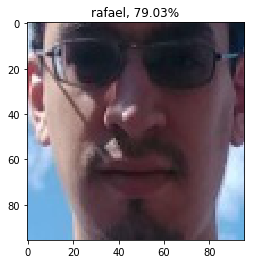

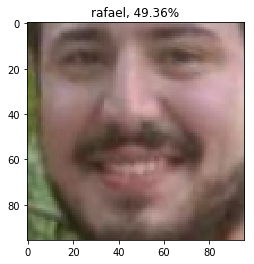

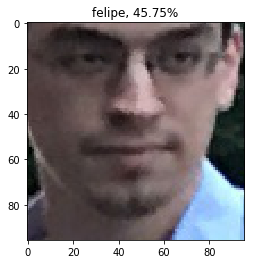

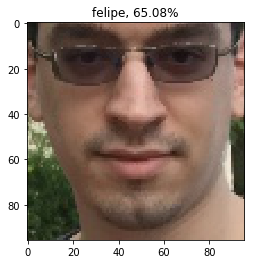

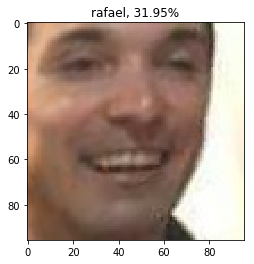

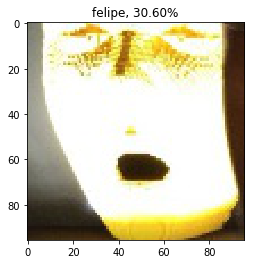

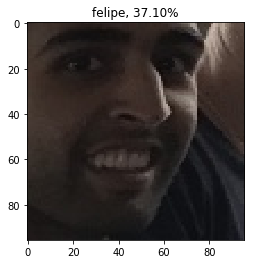

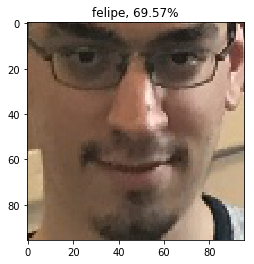

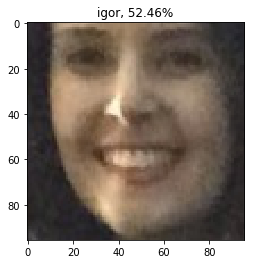

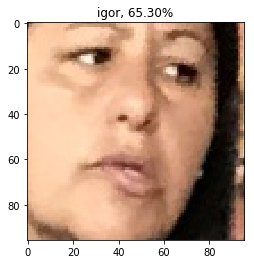

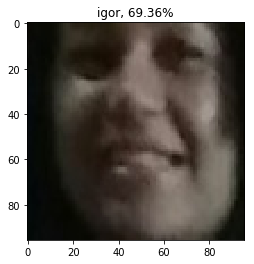

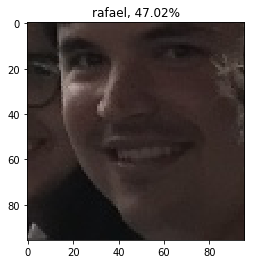

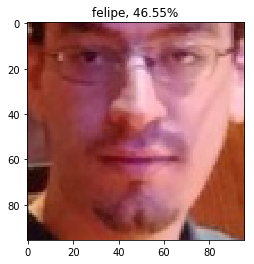

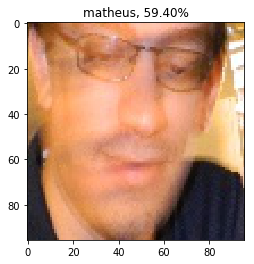

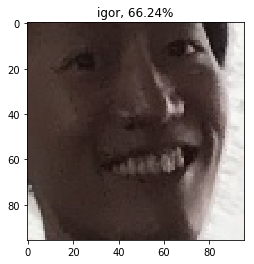

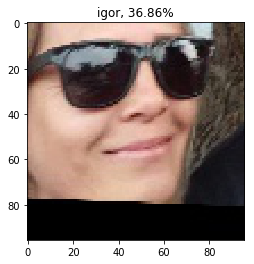

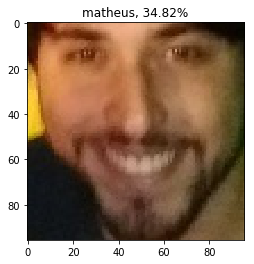

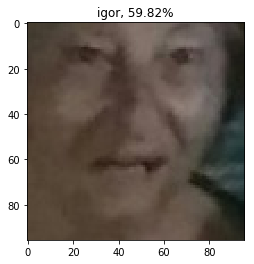

In [40]:
for i, image in enumerate(unk_faces):
    plt.figure()
    plt.imshow(image)
    idx = np.argmax(predict[i])
    plt.title('{}, {:.2f}%'.format(le.inverse_transform(idx), predict[i][idx]*100))

In [41]:
np.max(predict)

0.8454398699214275

In [45]:
sys.path.insert(0, '../../openface/')

In [46]:
import openface as _openface

In [47]:
net = _openface.TorchNeuralNet('../models/openface/nn4.small2.v1.t7')

In [50]:
X_of = [net.forward((x*255).astype(np.uint8)) for x in X]
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(X_of, y, X, test_size=0.2, random_state=42, stratify=y)
scores = cross_val_score(model, X_train, y_train, cv=5)

In [51]:
scores

array([ 0.9       ,  0.93333333,  0.93333333,  0.93333333,  0.93333333])

In [52]:
predict = cross_val_predict(model, X_npy, y, cv=10)

In [53]:
predict

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
predict = model.predict_proba(X_test)

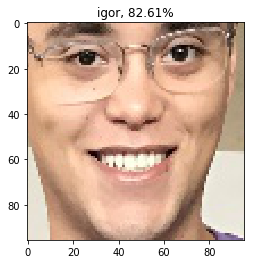

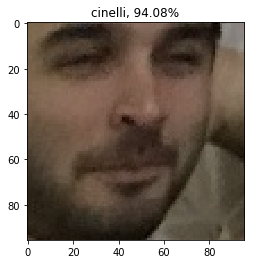

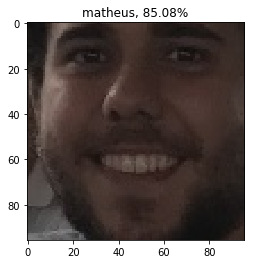

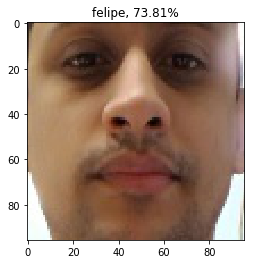

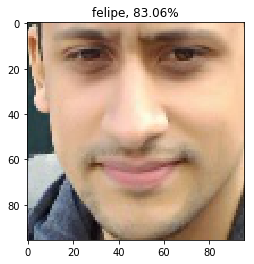

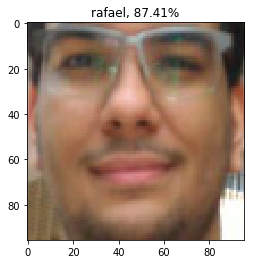

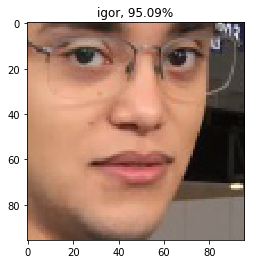

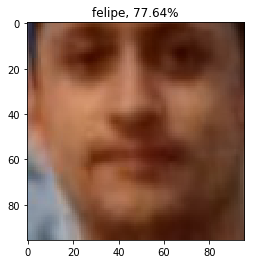

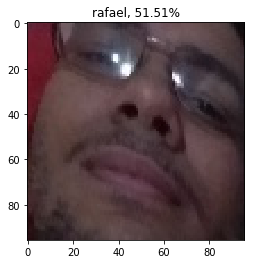

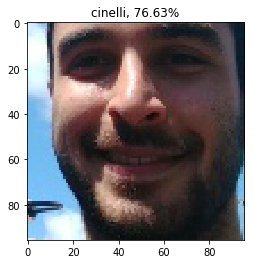

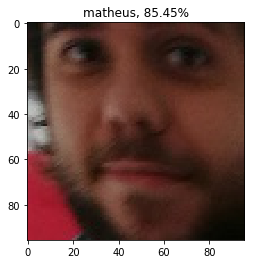

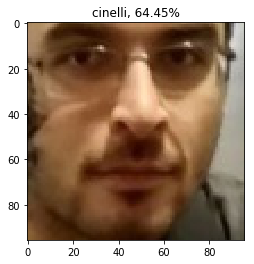

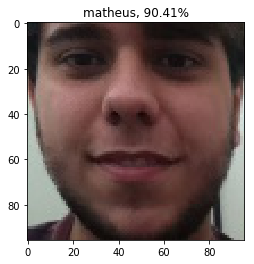

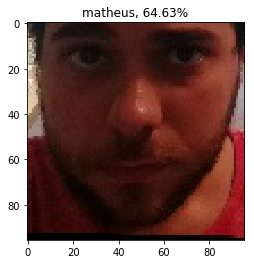

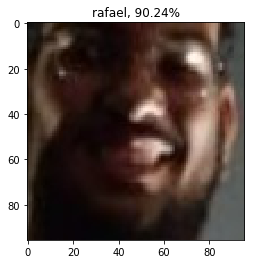

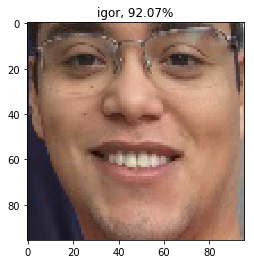

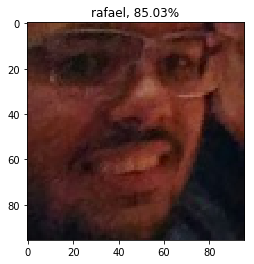

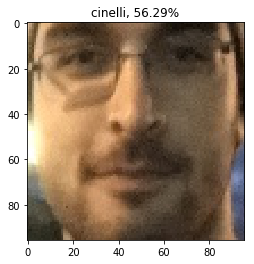

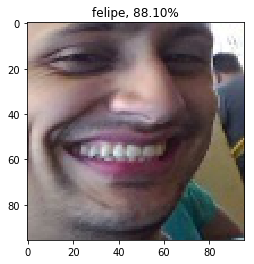

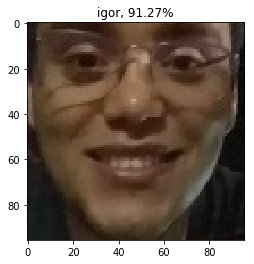

In [56]:
for i, image in enumerate(images_test):
    plt.figure()
    plt.imshow(image)
    idx = np.argmax(predict[i])
    plt.title('{}, {:.2f}%'.format(le.inverse_transform(idx), predict[i][idx]*100))

In [57]:
unk_emb = [net.forward((x*255).astype(np.uint8)) for x in unk_faces]

In [58]:
predict = model.predict_proba(unk_emb)

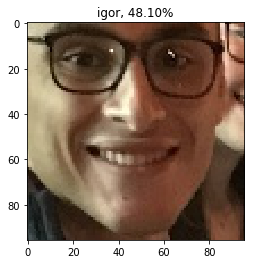

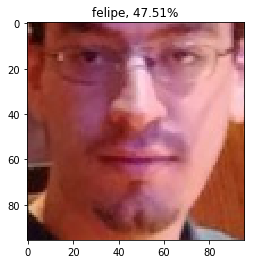

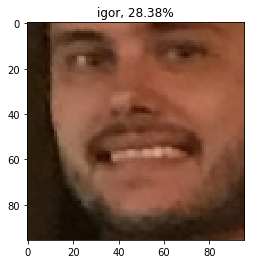

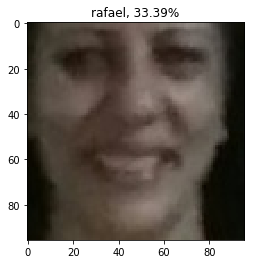

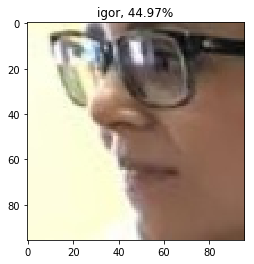

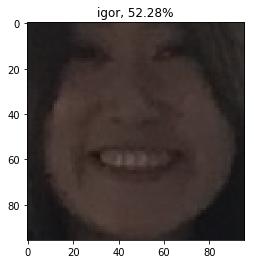

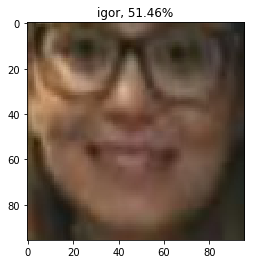

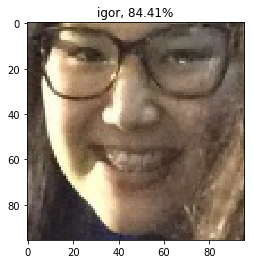

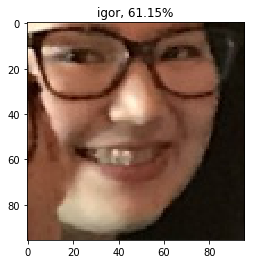

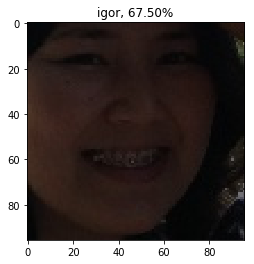

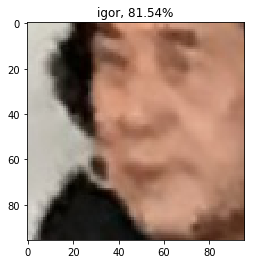

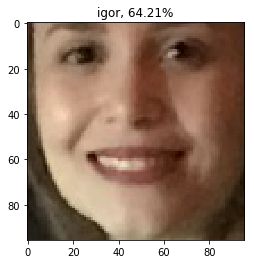

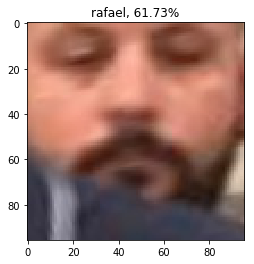

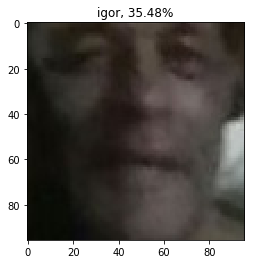

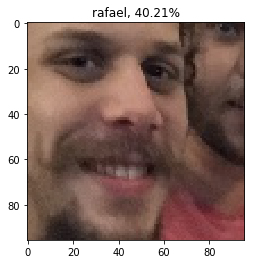

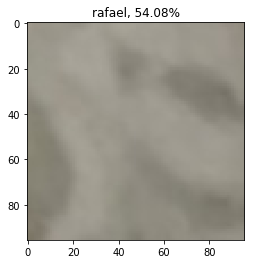

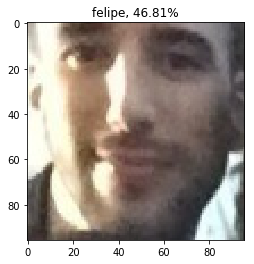

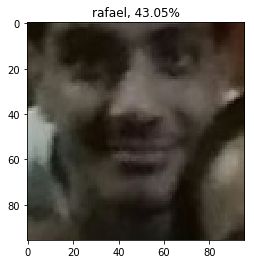

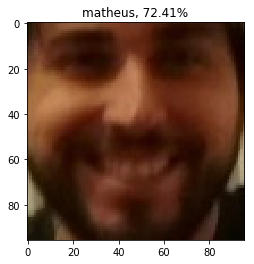

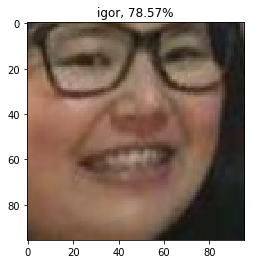

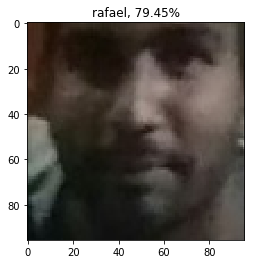

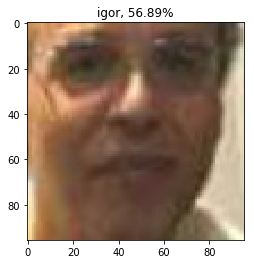

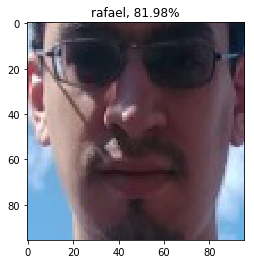

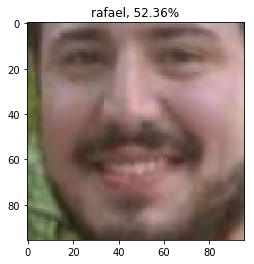

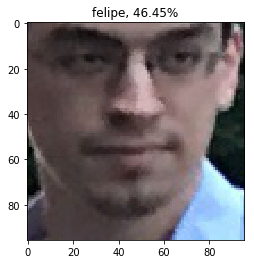

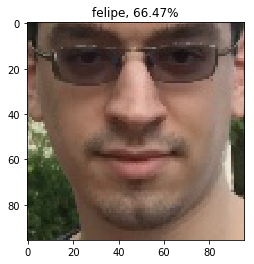

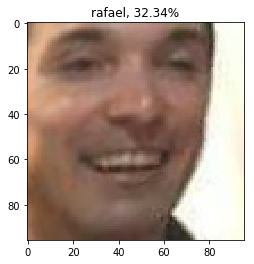

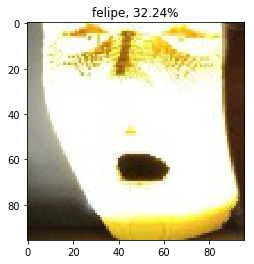

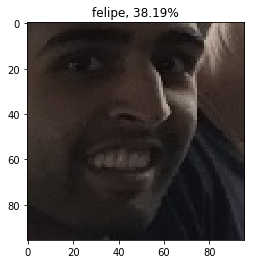

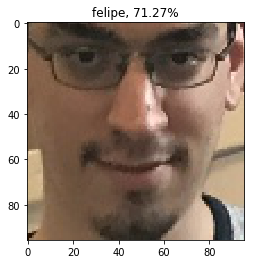

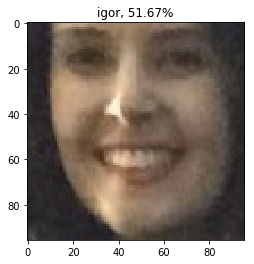

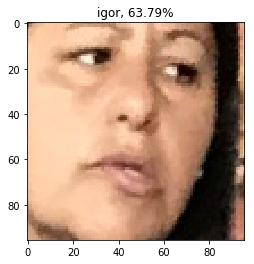

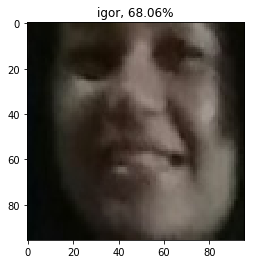

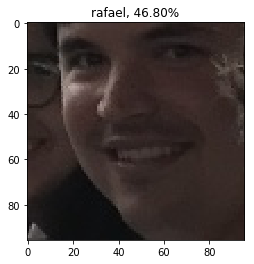

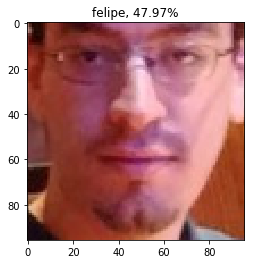

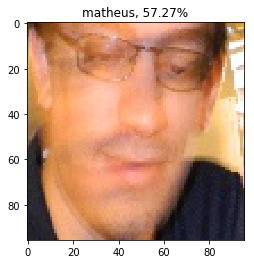

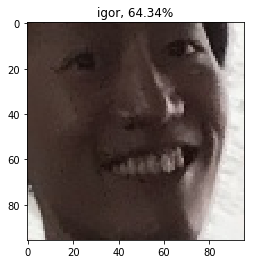

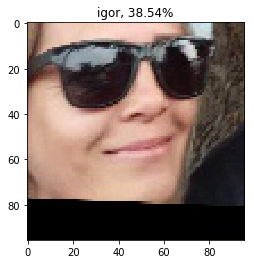

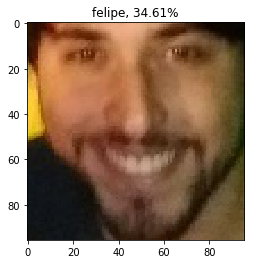

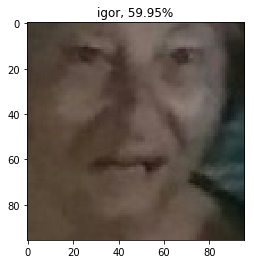

In [59]:
for i, image in enumerate(unk_faces):
    plt.figure()
    plt.imshow(image)
    idx = np.argmax(predict[i])
    plt.title('{}, {:.2f}%'.format(le.inverse_transform(idx), predict[i][idx]*100))

In [60]:
np.max(predict)

0.84414610476772955